In [1]:
# Import necessary libraries
import os
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import genpareto
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import genextreme
from sklearn.metrics import confusion_matrix, classification_report


os.chdir('/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/Data')

In [2]:
# Load the data
wo_pop_sim = gpd.read_file('wo_pop_sim_result.geojson')
# Load the data
pop_sim = gpd.read_file('w_pop_sim_result.geojson')

# Extreme Value Theory

## Without Logit Transformation

20% of the data goes into the test set and 80% into the training set.

Threshold to define what counts as an "extreme" value
-  95th percentile of the training data, all values above this threshold are considered "extreme"
-  visualize how much of the data is considered extreme

Fit GEV distribution

Fitted GEV parameters to exceedances:
  shape (c): -0.3424
  loc       : 0.8905
  scale     : 0.0178


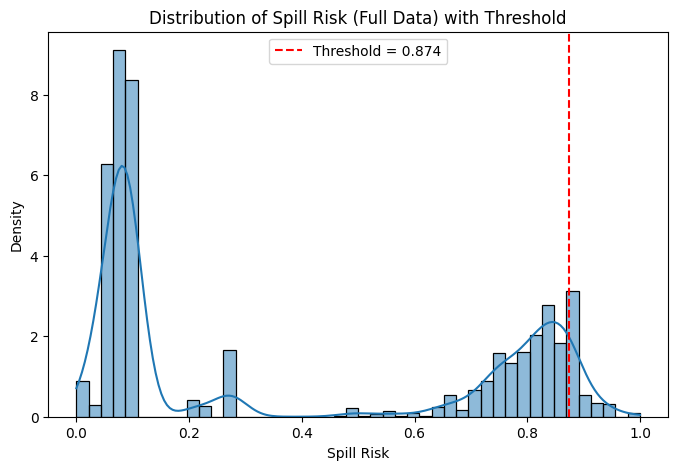

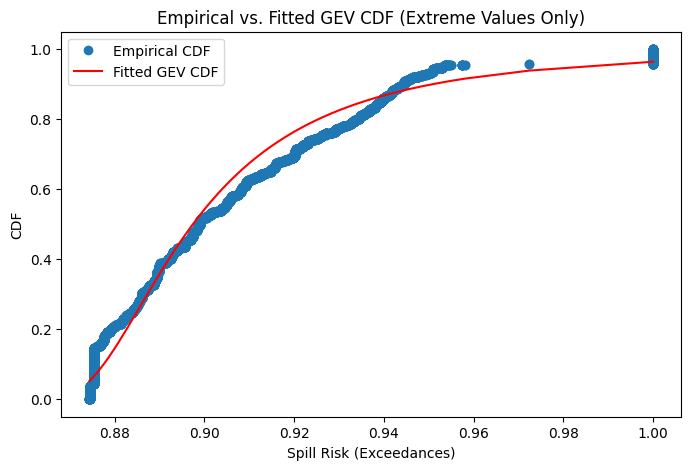


Return Period Comparison:
   Return Period  GEV_Theoretical  Empirical
0              2         0.897411   0.898927
1              5         0.925374   0.934497
2             10         0.950845   0.944514
3             20         0.982265   0.953198
4             50         1.036317   1.000000
5            100         1.089761   1.000000


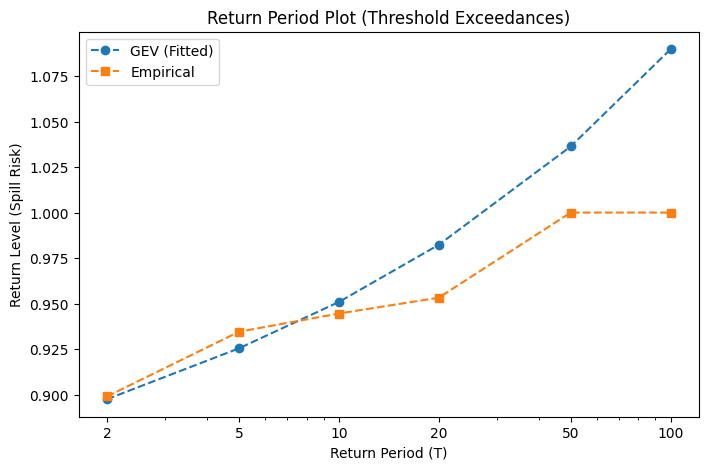

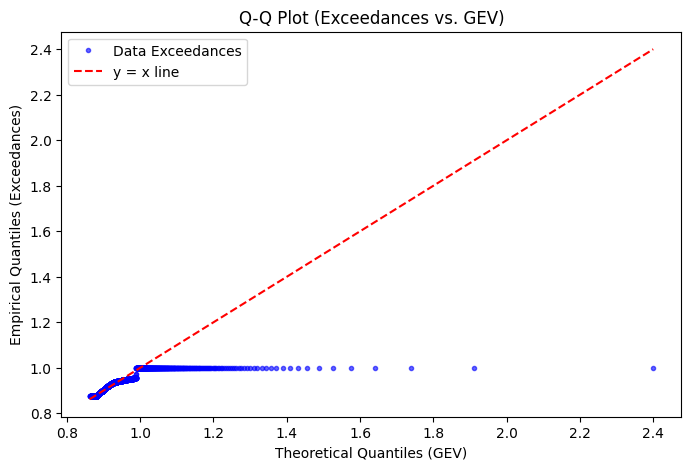

In [3]:
# --------------------------------------------------------
# 1) SPLIT DATA
# --------------------------------------------------------
train_df, test_df = train_test_split(wo_pop_sim, test_size=0.2, random_state=42)

# --------------------------------------------------------
# 2) THRESHOLD & EXCEEDANCES
# --------------------------------------------------------
threshold = train_df['risk_probability'].quantile(0.95)
extreme_values = train_df['risk_probability'][train_df['risk_probability'] > threshold]

# --------------------------------------------------------
# 3) FIT GEV TO EXCEEDANCES
# --------------------------------------------------------
shape, loc, scale = genextreme.fit(extreme_values)  # shape = c in SciPy's genextreme
print("Fitted GEV parameters to exceedances:")
print(f"  shape (c): {shape:.4f}")
print(f"  loc       : {loc:.4f}")
print(f"  scale     : {scale:.4f}")

# --------------------------------------------------------
# 4) PLOTS
# --------------------------------------------------------

# (A) DISTRIBUTION WITH THRESHOLD
plt.figure(figsize=(8,5))
sns.histplot(wo_pop_sim['risk_probability'], kde=True, stat='density')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.3f}')
plt.title('Distribution of Spill Risk (Full Data) with Threshold')
plt.xlabel('Spill Risk')
plt.ylabel('Density')
plt.legend()
plt.show()

# (B) EMPIRICAL vs. FITTED GEV CDF (EXTREME VALUES ONLY)
sorted_extremes = np.sort(extreme_values)
n_ext = len(sorted_extremes)
empirical_cdf = np.arange(1, n_ext + 1) / (n_ext + 1)
gev_cdf = genextreme.cdf(sorted_extremes, shape, loc=loc, scale=scale)

plt.figure(figsize=(8,5))
plt.plot(sorted_extremes, empirical_cdf, marker='o', linestyle='none', label='Empirical CDF')
plt.plot(sorted_extremes, gev_cdf, color='red', label='Fitted GEV CDF')
plt.title('Empirical vs. Fitted GEV CDF (Extreme Values Only)')
plt.xlabel('Spill Risk (Exceedances)')
plt.ylabel('CDF')
plt.legend()
plt.show()

# (C) RETURN PERIOD PLOT
return_periods = [2, 5, 10, 20, 50, 100]
theoretical_levels = []
empirical_levels = []

sorted_exceed = np.sort(extreme_values)
n_exceed = len(sorted_exceed)

for T in return_periods:
    # GEV-based theoretical quantile at 1 - 1/T
    p = 1 - 1/T
    q_T = genextreme.ppf(p, shape, loc=loc, scale=scale)
    theoretical_levels.append(q_T)
    
    # Empirical quantile at the same probability
    idx = int(np.ceil(p * n_exceed)) - 1
    idx = max(idx, 0)
    idx = min(idx, n_exceed - 1)
    empirical_levels.append(sorted_exceed[idx])

df_return = pd.DataFrame({
    "Return Period": return_periods,
    "GEV_Theoretical": theoretical_levels,
    "Empirical": empirical_levels
})
print("\nReturn Period Comparison:")
print(df_return)

plt.figure(figsize=(8,5))
plt.plot(df_return["Return Period"], df_return["GEV_Theoretical"], 'o--', label='GEV (Fitted)')
plt.plot(df_return["Return Period"], df_return["Empirical"], 's--', label='Empirical')
plt.xscale('log')  # Log scale for T is common
desired_ticks = [2, 5, 10, 20, 50, 100]
plt.xticks(desired_ticks, labels=desired_ticks)
plt.xlabel("Return Period (T)")
plt.ylabel("Return Level (Spill Risk)")
plt.title("Return Period Plot (Threshold Exceedances)")
plt.legend()
plt.show()

# (D) Q-Q PLOT
emp_probs = (np.arange(1, n_exceed + 1) - 0.5) / n_exceed
theoretical_q = genextreme.ppf(emp_probs, shape, loc=loc, scale=scale)

plt.figure(figsize=(8,5))
plt.plot(theoretical_q, sorted_exceed, 'b.', alpha=0.6, label='Data Exceedances')
mn = min(theoretical_q.min(), sorted_exceed.min())
mx = max(theoretical_q.max(), sorted_exceed.max())
plt.plot([mn, mx], [mn, mx], 'r--', label='y = x line')
plt.xlabel("Theoretical Quantiles (GEV)")
plt.ylabel("Empirical Quantiles (Exceedances)")
plt.title("Q-Q Plot (Exceedances vs. GEV)")
plt.legend()
plt.show()

## With Logit Transformation

Fitted GEV parameters (in LOGIT space):
  shape (c): -1.0165
  loc       : 2.0624
  scale     : 0.1731


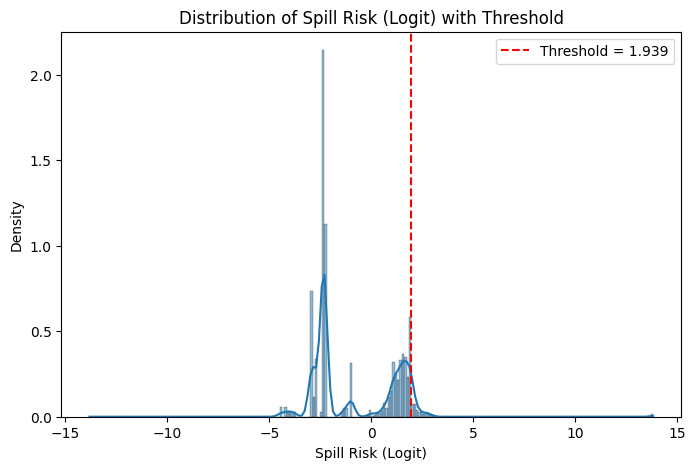

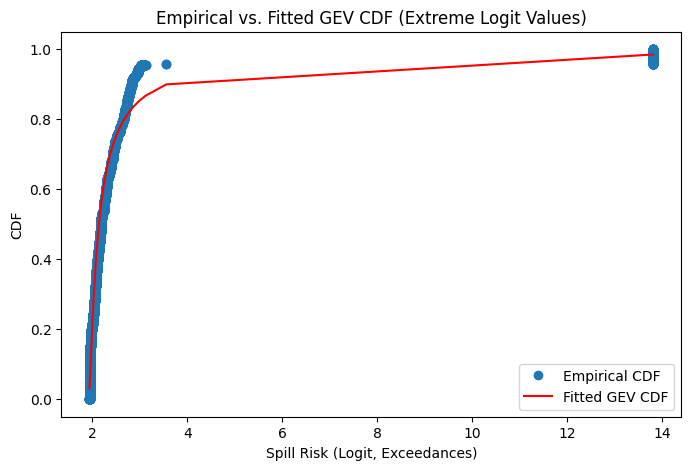


Return Period Comparison (logit scale):
   Return Period  GEV_Theoretical  Empirical
0              2         2.139246   2.185363
1              5         2.674280   2.657905
2             10         3.569294   2.834539
3             20         5.378296   3.013900
4             50        10.880253  13.815510
5            100        20.168718  13.815510


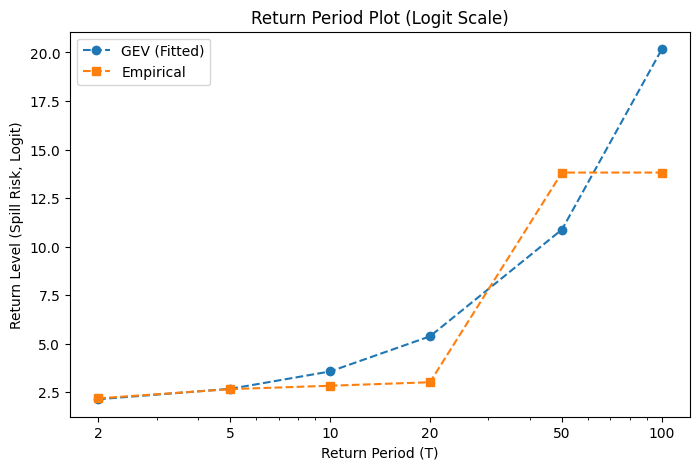

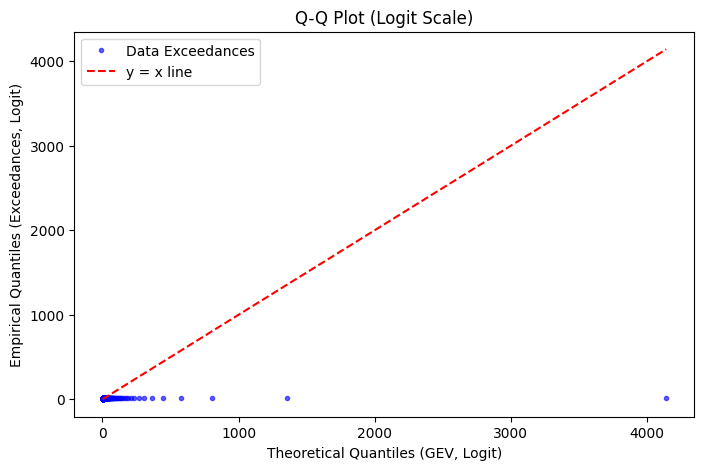

In [ ]:
# --------------------------------------------------------
# 0) HELPER FUNCTIONS
# --------------------------------------------------------
def inverse_logit(x):
    return 1 / (1 + np.exp(-x))

def logit(p, eps=1e-6):
    p_clipped = np.clip(p, eps, 1 - eps)
    return np.log(p_clipped / (1 - p_clipped))

# --------------------------------------------------------
# 1) SPLIT DATA & CREATE LOGIT COLUMN
# --------------------------------------------------------
wo_pop_sim["risk_logit"] = wo_pop_sim["risk_probability"].apply(logit)
train_df, test_df = train_test_split(wo_pop_sim, test_size=0.2, random_state=42)

# --------------------------------------------------------
# 2) FIND THRESHOLD & EXTREME VALUES (LOGIT SPACE)
# --------------------------------------------------------
threshold = train_df['risk_logit'].quantile(0.95)
extreme_values = train_df['risk_logit'][train_df['risk_logit'] > threshold]

# --------------------------------------------------------
# 3) FIT GEV (LOGIT SPACE)
# --------------------------------------------------------
shape, loc, scale = genextreme.fit(extreme_values)

print("Fitted GEV parameters (in LOGIT space):")
print(f"  shape (c): {shape:.4f}")
print(f"  loc       : {loc:.4f}")
print(f"  scale     : {scale:.4f}")

# --------------------------------------------------------
# 4a) DISTRIBUTION & THRESHOLD PLOT (LOGIT SPACE) [ORIGINAL CODE]
# --------------------------------------------------------
plt.figure(figsize=(8,5))
sns.histplot(wo_pop_sim['risk_logit'], kde=True, stat='density')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.3f}')
plt.title('Distribution of Spill Risk (Logit) with Threshold')
plt.xlabel('Spill Risk (Logit)')
plt.ylabel('Density')
plt.legend()
plt.show()

# --------------------------------------------------------
# 4b) EMPIRICAL vs. FITTED GEV CDF (EXTREME VALUES, LOGIT SPACE)
# --------------------------------------------------------
sorted_extremes = np.sort(extreme_values)
n_ext = len(sorted_extremes)
empirical_cdf = np.arange(1, n_ext + 1) / (n_ext + 1)
gev_cdf = genextreme.cdf(sorted_extremes, c=shape, loc=loc, scale=scale)

plt.figure(figsize=(8,5))
plt.plot(sorted_extremes, empirical_cdf, marker='o', linestyle='none', label='Empirical CDF')
plt.plot(sorted_extremes, gev_cdf, color='red', label='Fitted GEV CDF')
plt.title('Empirical vs. Fitted GEV CDF (Extreme Logit Values)')
plt.xlabel('Spill Risk (Logit, Exceedances)')
plt.ylabel('CDF')
plt.legend()
plt.show()

# --------------------------------------------------------
# 4c) RETURN PERIOD PLOT (LOGIT SPACE)
# --------------------------------------------------------
return_periods = [2, 5, 10, 20, 50, 100]
theoretical_levels = []
empirical_levels = []

for T in return_periods:
    p = 1 - 1/T
    q_T = genextreme.ppf(p, c=shape, loc=loc, scale=scale)   # logit-scale
    theoretical_levels.append(q_T)
    
    idx = int(np.ceil(p * n_ext)) - 1
    idx = max(idx, 0)
    idx = min(idx, n_ext - 1)
    empirical_levels.append(sorted_extremes[idx])

df_return = pd.DataFrame({
    "Return Period": return_periods,
    "GEV_Theoretical": theoretical_levels,
    "Empirical": empirical_levels
})
print("\nReturn Period Comparison (logit scale):")
print(df_return)

plt.figure(figsize=(8,5))
plt.plot(df_return["Return Period"], df_return["GEV_Theoretical"], 'o--', label='GEV (Fitted)')
plt.plot(df_return["Return Period"], df_return["Empirical"], 's--', label='Empirical')
plt.xscale('log')  # Log scale for T
plt.xticks(return_periods, labels=return_periods)
plt.xlabel("Return Period (T)")
plt.ylabel("Return Level (Spill Risk, Logit)")
plt.title("Return Period Plot (Logit Scale)")
plt.legend()
plt.show()

# --------------------------------------------------------
# 4d) Q-Q PLOT (LOGIT SCALE)
# --------------------------------------------------------
emp_probs = (np.arange(1, n_ext + 1) - 0.5) / n_ext
theoretical_q = genextreme.ppf(emp_probs, c=shape, loc=loc, scale=scale)

plt.figure(figsize=(8,5))
plt.plot(theoretical_q, sorted_extremes, 'b.', alpha=0.6, label='Data Exceedances')
mn = min(theoretical_q.min(), sorted_extremes.min())
mx = max(theoretical_q.max(), sorted_extremes.max())
plt.plot([mn, mx], [mn, mx], 'r--', label='y = x line')
plt.xlabel("Theoretical Quantiles (GEV, Logit)")
plt.ylabel("Empirical Quantiles (Exceedances, Logit)")
plt.title("Q-Q Plot (Logit Scale)")
plt.legend()
plt.show()

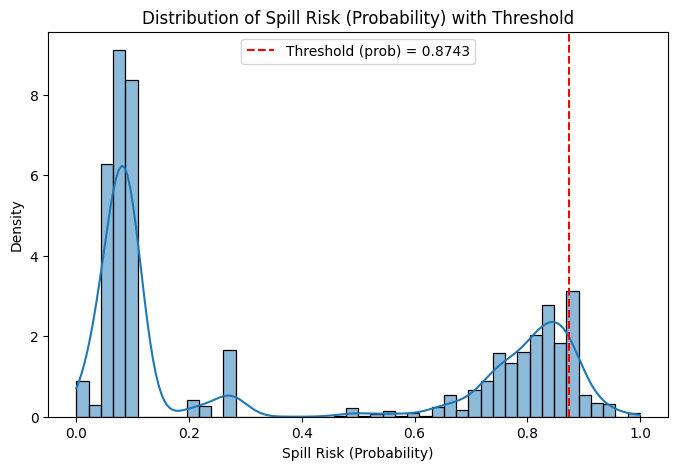

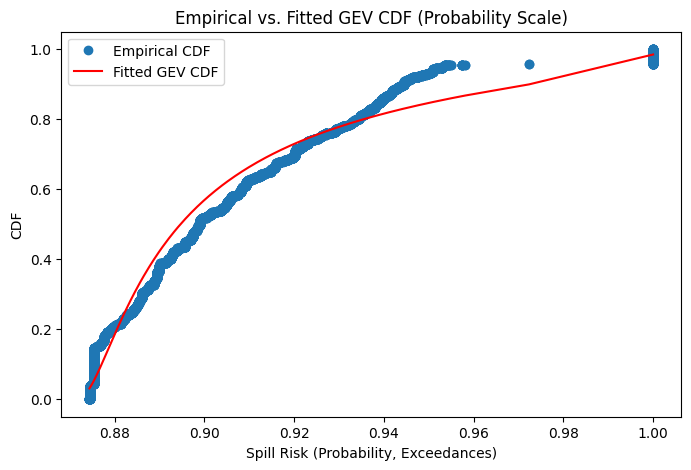


Return Period Comparison (probability scale):
   Return Period  GEV_Theoretical_Prob  Empirical_Prob
0              2              0.894660        0.898927
1              5              0.935492        0.934497
2             10              0.972596        0.944514
3             20              0.995406        0.953198
4             50              0.999981        0.999999
5            100              1.000000        0.999999


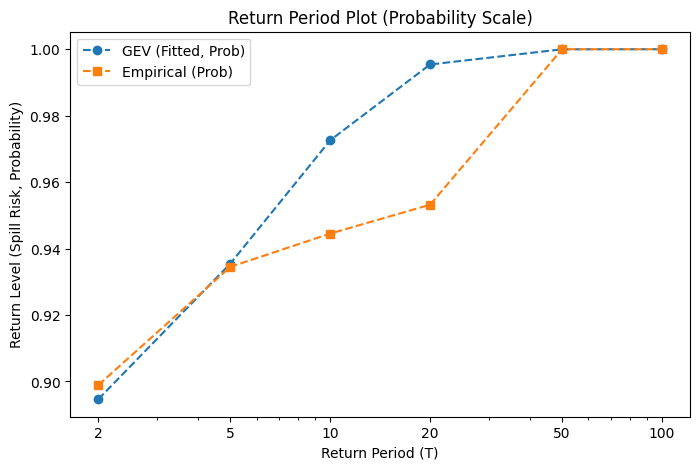

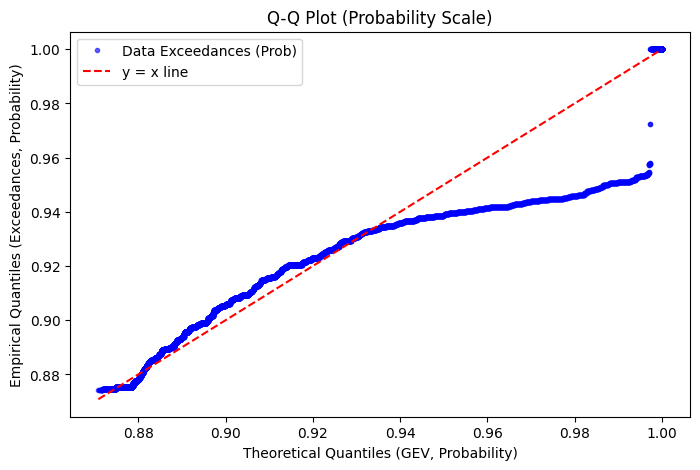

In [7]:
# ========================================================
# INVERSE-LOGIT TRANSFORM & PLOTS IN PROBABILITY SPACE
# ========================================================

# --------------------------------------------------------
# A) DISTRIBUTION WITH THRESHOLD (PROBABILITY SCALE)
# --------------------------------------------------------
# Convert threshold from logit to probability scale
threshold_prob = inverse_logit(threshold)

# Convert entire distribution to probability scale
wo_pop_sim['risk_prob_from_logit'] = inverse_logit(wo_pop_sim['risk_logit'])

plt.figure(figsize=(8,5))
sns.histplot(wo_pop_sim['risk_prob_from_logit'], kde=True, stat='density')
plt.axvline(threshold_prob, color='red', linestyle='--', 
            label=f'Threshold (prob) = {threshold_prob:.4f}')
plt.title('Distribution of Spill Risk (Probability) with Threshold')
plt.xlabel('Spill Risk (Probability)')
plt.ylabel('Density')
plt.legend()
plt.show()

# --------------------------------------------------------
# B) EMPIRICAL vs. FITTED GEV CDF (EXTREME VALUES IN PROB SPACE)
# --------------------------------------------------------
# Sort extreme values (logit) and transform to probability scale
sorted_extremes_prob = inverse_logit(sorted_extremes)

# Empirical CDF is the same numeric array [1/(n+1), ..., n/(n+1)],
# but we'll just plot it vs. the probability-scale x-axis
empirical_cdf_prob = empirical_cdf  # same array as before

# Fitted GEV CDF at each logit value is the same `gev_cdf`, 
# but we want to plot it vs. the probability-scale x-axis.
fitted_cdf_prob = gev_cdf  # same array, because input was sorted_extremes (logit)

plt.figure(figsize=(8,5))
plt.plot(sorted_extremes_prob, empirical_cdf_prob, 'o', label='Empirical CDF')
plt.plot(sorted_extremes_prob, fitted_cdf_prob, 'r-', label='Fitted GEV CDF')
plt.title('Empirical vs. Fitted GEV CDF (Probability Scale)')
plt.xlabel('Spill Risk (Probability, Exceedances)')
plt.ylabel('CDF')
plt.legend()
plt.show()

# --------------------------------------------------------
# C) RETURN PERIOD PLOT (PROBABILITY SCALE)
# --------------------------------------------------------
theoretical_levels_prob = []
empirical_levels_prob = []

for T in return_periods:
    p = 1 - 1/T
    # q_T is in logit scale
    q_T = genextreme.ppf(p, c=shape, loc=loc, scale=scale)
    # convert to probability scale
    theoretical_levels_prob.append(inverse_logit(q_T))
    
    # find the empirical exceedance in logit scale, then transform
    idx = int(np.ceil(p * n_ext)) - 1
    idx = max(idx, 0)
    idx = min(idx, n_ext - 1)
    q_emp_logit = sorted_extremes[idx]
    q_emp_prob = inverse_logit(q_emp_logit)
    empirical_levels_prob.append(q_emp_prob)

df_return_prob = pd.DataFrame({
    "Return Period": return_periods,
    "GEV_Theoretical_Prob": theoretical_levels_prob,
    "Empirical_Prob": empirical_levels_prob
})

print("\nReturn Period Comparison (probability scale):")
print(df_return_prob)

plt.figure(figsize=(8,5))
plt.plot(df_return_prob["Return Period"], 
         df_return_prob["GEV_Theoretical_Prob"], 'o--', label='GEV (Fitted, Prob)')
plt.plot(df_return_prob["Return Period"], 
         df_return_prob["Empirical_Prob"], 's--', label='Empirical (Prob)')
plt.xscale('log')  # log scale for T
plt.xticks(return_periods, labels=return_periods)
plt.xlabel("Return Period (T)")
plt.ylabel("Return Level (Spill Risk, Probability)")
plt.title("Return Period Plot (Probability Scale)")
plt.legend()
plt.show()

# --------------------------------------------------------
# D) Q-Q PLOT (PROBABILITY SCALE)
# --------------------------------------------------------
# theoretical_q: array of logit-scale quantiles
# sorted_extremes: array of logit-scale data
# Convert both to probability scale
theoretical_q_prob = inverse_logit(theoretical_q)
sorted_extremes_prob = inverse_logit(sorted_extremes)

plt.figure(figsize=(8,5))
plt.plot(theoretical_q_prob, sorted_extremes_prob, 'b.', alpha=0.6, 
         label='Data Exceedances (Prob)')
mn = min(theoretical_q_prob.min(), sorted_extremes_prob.min())
mx = max(theoretical_q_prob.max(), sorted_extremes_prob.max())
plt.plot([mn, mx], [mn, mx], 'r--', label='y = x line')
plt.xlabel("Theoretical Quantiles (GEV, Probability)")
plt.ylabel("Empirical Quantiles (Exceedances, Probability)")
plt.title("Q-Q Plot (Probability Scale)")
plt.legend()
plt.show()

In [ ]:
# --------------------------------------------------------
# 5) CONFUSION MATRIX
# --------------------------------------------------------

observed_high_risk = (test_df['risk_logit'] > threshold).astype(int)

gev_threshold_95 = genextreme.ppf(0.95, c=shape, loc=loc, scale=scale)

predicted_high_risk = (test_df['risk_logit'] > gev_threshold_95).astype(int)

cm = confusion_matrix(observed_high_risk, predicted_high_risk)
labels = ["Low Risk", "High Risk"]  # order: 0 -> Low, 1 -> High

print("\nConfusion Matrix (Numerical): [Test Set]")
print(cm)
print("Format: [[TN, FP], [FN, TP]]")

print("\nClassification Report:")
print(classification_report(observed_high_risk, predicted_high_risk, target_names=labels))

plt.figure(figsize=(6,5))
ax = sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=labels, yticklabels=labels
)
ax.set_xlabel("Predicted Label")
ax.set_ylabel("Observed Label")
ax.set_title("Confusion Matrix: Low Risk vs. High Risk (Test Set)")
plt.show()